# Imports

In [1]:
import pandas as pd
import psycopg
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import scipy.stats as stats
import seaborn as sb
import re
from collections import Counter

In [4]:
mc = pd.read_csv('output/metric_changes.csv')
mc['pct_change'] = ((mc['2025'] - mc['2022']) / mc['2022']) * 100
mc.to_csv('output/metric_changes_pct.csv')

In [3]:
db_conn_info = os.getenv('DB_CONN_INFO')

In [4]:
plt.style.use("dark_background")

# Clean Data

In [5]:
def query_to_df(query):
    with psycopg.connect(db_conn_info) as conn:
        with conn.cursor() as cur:
            cur.execute(query)
            columns = [desc[0] for desc in cur.description]
            data = cur.fetchall()
            df = pd.DataFrame(data, columns=columns)
    return df

For convenience sake, we will just join the two tables into one super table so that all the data we need is in one table.

In [6]:
df = query_to_df("SELECT * FROM fictions f LEFT JOIN patreons p ON f.patreon_id = p.patreon_id;")
df = df.sort_values(["followers",  "patron_count"], ascending=False)
df.shape

(82534, 22)

In [7]:
duplicates_only = df[df.duplicated(subset=["title", "author"], keep=False)]
duplicates_only = duplicates_only.sort_values(by=["title", "author"]).reset_index(drop=True)
duplicates_only[["title", "author", "followers", "ratings", "patron_count"]]

,title,author,followers,ratings,patron_count
0,I am the Game's Extra,Dark God,5,0,NaN
1,I am the Game's Extra,Dark God,0,0,NaN
2,(WIP) The Enigma On Track 13,doc47,1,0,NaN
3,(WIP) The Enigma On Track 13,doc47,0,0,NaN
4,---,dff123,74,28,NaN
...,...,...,...,...,...
289,na,Travis Johnston,14,2,NaN
290,na,Travis Johnston,7,1,NaN
291,na,Travis Johnston,3,1,NaN
292,removed,baa_sleep,11,9,NaN


In [8]:
df = df.drop_duplicates(subset=["title", "author"], keep="first").reset_index(drop=True)
df.shape

(82374, 22)

In [9]:
df.describe()

,fiction_id,total_views,average_views,followers,favorites,ratings,pages,total_chapters,first_chapter_release_datetime,patreon_id,patreon_id,creation_count,patron_count,member_count,paid_member_count
count,82374.000000,8.237400e+04,82374.000000,82374.000000,82374.000000,82374.000000,82374.000000,82374.000000,76288,11217.000000,11217.000000,8162.000000,3304.000000,76.000000,6.000000
mean,41247.221283,5.086830e+04,861.112560,109.882257,33.982616,25.827640,141.846578,17.255481,2021-10-03 03:53:51.640939520,2549.462958,2549.462958,187.518868,367.626816,11.157895,7.166667
min,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2013-03-30 00:06:20,1.000000,1.000000,1.000000,11.000000,1.000000,2.000000
25%,20605.250000,1.940000e+02,89.000000,0.000000,0.000000,0.000000,6.000000,1.000000,2019-11-02 22:10:30.500000,1284.000000,1284.000000,13.000000,34.000000,1.000000,6.000000
50%,41232.500000,9.860000e+02,182.000000,3.000000,1.000000,1.000000,28.000000,4.000000,2022-07-25 22:27:04.500000,2513.000000,2513.000000,65.000000,83.000000,1.000000,9.000000
75%,61888.750000,5.832750e+03,627.000000,18.000000,5.000000,4.000000,116.000000,16.000000,2024-03-17 10:37:27,3810.000000,3810.000000,222.000000,266.000000,5.000000,9.000000
max,82534.000000,4.843697e+07,197671.000000,33713.000000,24710.000000,14129.000000,16110.000000,1759.000000,2025-02-18 23:09:03,5147.000000,5147.000000,3814.000000,18620.000000,162.000000,9.000000
std,23829.891253,5.285066e+05,3068.366272,659.025115,274.163684,195.994998,402.181468,43.826145,NaN,1470.038440,1470.038440,339.989935,909.998811,36.015572,2.994439


In [10]:
df[['title', 'author']].describe(include='O')

,title,author
count,82374,82374
unique,79931,52436
top,.,Royalist
freq,29,62


In [11]:
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

first_chapter_release_datetime     6086
patreon_id                        71157
patreon_id                        71157
patreon_link                      71157
creation_count                    74212
patron_count                      79070
monthly_earnings                  79449
member_count                      82298
paid_member_count                 82368
dtype: int64


In [12]:
zero_counts = (df == 0).sum()
print(zero_counts[zero_counts > 0])

total_views        6083
average_views      6083
followers         20897
favorites         35620
ratings           39260
pages              7419
total_chapters     6086
dtype: int64


Also interested in how many patreon owners disclose their stats.

In [13]:
patreons = query_to_df("SELECT * FROM patreons")

In [14]:
patreons.describe(include='all')

,patreon_id,patreon_link,creation_count,patron_count,monthly_earnings,member_count,paid_member_count
count,5147.000000,5147,3679.000000,1229.000000,1165,27.000000,3.000000
unique,NaN,5147,NaN,NaN,962,NaN,NaN
top,NaN,https://www.patreon.com/mysticwise,NaN,NaN,6.77,NaN,NaN
freq,NaN,1,NaN,NaN,19,NaN,NaN
mean,2574.000000,NaN,140.761076,350.374288,NaN,10.000000,5.333333
std,1485.955248,NaN,278.982279,1118.226599,NaN,31.014885,3.511885
min,1.000000,NaN,1.000000,11.000000,NaN,1.000000,2.000000
25%,1287.500000,NaN,9.000000,28.000000,NaN,1.000000,3.500000
50%,2574.000000,NaN,46.000000,73.000000,NaN,2.000000,5.000000
75%,3860.500000,NaN,150.000000,233.000000,NaN,4.000000,7.000000


Also, if we look at patreons and which ones disclose their stats, do those who are more established tend to disclose their stats more?

In [96]:
patreon_disclosures = query_to_df("""
SELECT DISTINCT patreon_link, SUM(followers) AS followers,
CASE
	WHEN monthly_earnings IS NOT NULL THEN 1
	ELSE 0
END AS disclosed_monthly_earnings,
CASE
	WHEN patron_count IS NOT NULL THEN 1
	ELSE 0
END AS disclosed_patron_count
FROM fictions f LEFT JOIN patreons p ON f.patreon_id = p.patreon_id
WHERE p.patreon_link IS NOT NULL
GROUP BY p.patreon_id
ORDER BY followers DESC;
""")

patreon_disclosures.head()

,patreon_link,followers,disclosed_monthly_earnings,disclosed_patron_count
0,https://www.patreon.com/VoidHerald,70312,0,1
1,https://www.patreon.com/RavensDagger,66975,0,1
2,https://www.patreon.com/Actus,52371,1,1
3,https://www.patreon.com/nobody103,47671,1,1
4,https://www.patreon.com/Macronomicon,41658,1,1


In [97]:
disclosed_monthly_earnings = patreon_disclosures[patreon_disclosures["disclosed_monthly_earnings"] == 1]["followers"]
not_disclosed_monthly_earnings = patreon_disclosures[patreon_disclosures["disclosed_monthly_earnings"] == 0]["followers"]

t_stat, p_value = stats.ttest_ind(disclosed_monthly_earnings, not_disclosed_monthly_earnings, equal_var=False)

print("MONTHLY_EARNINGS")
print(f"Mean Followers (Disclosed): {disclosed_monthly_earnings.mean():,.2f}")
print(f"Mean Followers (Not Disclosed): {not_disclosed_monthly_earnings.mean():,.2f}")
print(f"T-test p-value: {p_value}")

disclosed_patron_count = patreon_disclosures[patreon_disclosures["disclosed_patron_count"] == 1]["followers"]
not_disclosed_patron_count = patreon_disclosures[patreon_disclosures["disclosed_patron_count"] == 0]["followers"]

t_stat, p_value = stats.ttest_ind(disclosed_patron_count, not_disclosed_patron_count, equal_var=False)
print("PATRON_COUNT")
print(f"Mean Followers (Disclosed): {disclosed_patron_count.mean():,.2f}")
print(f"Mean Followers (Not Disclosed): {not_disclosed_patron_count.mean():,.2f}")
print(f"T-test p-value: {p_value}")

MONTHLY_EARNINGS
Mean Followers (Disclosed): 2,498.19
Mean Followers (Not Disclosed): 723.18
T-test p-value: 1.6367820088036322e-32
PATRON_COUNT
Mean Followers (Disclosed): 3,685.37
Mean Followers (Not Disclosed): 321.79
T-test p-value: 1.5419493939719127e-71


So from the t-tests, although we expected that the amount of followers didn't impact whether an author disclosed their monthly earnings and patron count, we found that were was a huge difference in the amount of followers of those who disclosed their stats vs didn't. Authors with more followers felt more comfortable with disclosing their earnings and patron count. 

Observations about the data:
- There are 82374 unique fictions collected as of 17th February 2025. There were also 5147 unique patreons. 
- There are 79931 unique title names, and 52436 unique authors. Duplicate titles usually occur because dropped fictions may be renamed '.' (29 such named fictions), however perhaps some people had similar naming choices. 'Royalist' is the author with the most fictions to their name, with 62.
- There are a lot of NA values. Patreon stats are entirely up to the owner to disclose, and some fictions have NA first chapter release dates due to not having a first chapter (deleted/not uploaded).
- Out of the 5147 patreons, 71% (3679/5147) disclosed their creation count, 24% (1229/5147) disclosed their patron count and 23% (1165/5147) disclosed their monthly earnings. 
- We found that there is significant evidence that more established fictions disclose their patreon stats. We should keep this in mind as we analyse the data.
- There are a lot of zero values. The majority of RoyalRoad is full of new fictions, or ones that might unfortunately not get attention. 

# Sam Hinton CosmicCoding Analysis with 2025 data

In [15]:
sh = pd.read_csv('samhinton/RR_stats.csv')
print("2022 Gathered RoyalRoad Information")
print(f"Fiction Count: {len(sh)}")
print(f"Total Views (Across All Fictions): {sh['Total Views'].sum()}")
print(f"Established fiction count (followers > 100): {len(sh[sh['Followers'] > 100])}")

2022 Gathered RoyalRoad Information
Fiction Count: 8877
Total Views (Across All Fictions): 961673909.0
Established fiction count (followers > 100): 1386


In [17]:
print("2025 Gathered RoyalRoad Information")
print(f"Fiction Count: {len(df)}")
print(f"Total Views (Across All Fictions): {df['total_views'].sum()}")
print(f"Established fiction count (followers > 100): {len(df[df['followers'] > 100])}")

2025 Gathered RoyalRoad Information
Fiction Count: 82374
Total Views (Across All Fictions): 4190225269
Established fiction count (followers > 100): 8906


Disclaimer that the 2025 data is on all fictions from the search tab, while 2022 data is on Latest Updates tab. 

In [18]:
# Credits to Sam Hinton, the author of this function. 
# Made some small adjustments like adding more arguments.
def plot_hist(df, col, quantiles=[0.5, 0.9, 0.99], bins=50, xlim=None, qfmt="%0.0f", fig_size = (12, 6), font_size=12, color="skyblue", title=None, **kw):
    _, ax = plt.subplots(figsize=fig_size)
    
    if xlim is None:
        xlim = (df[col].min(), df[col].max())
    y, x, _ = ax.hist(df[col], bins=np.linspace(*xlim, bins), color=color, **kw)  # Set histogram color
    xc = 0.5 * (x[1:] + x[:-1])
    
    if quantiles:
        interp = interp1d(xc, y, bounds_error=False, fill_value=(y[0], y[-1]))
        for q, q_val in zip(quantiles, df[col].quantile(quantiles)):
            qstr = qfmt % q_val
            qy = interp(q_val) + 0.03 * y.max()
            ax.axvline(q_val, alpha=0.5, ls=":", lw=1)
            ax.annotate(f"{1-q:0.0%} > {qstr} {col}", (q_val, qy), fontsize=font_size)  # Font size adjustment

    if title is not None:
        ax.set_title(title)
    ax.tick_params(axis='both', labelsize=font_size) 
    ax.set_xlim(*xlim)
    ax.set_xlabel(col, fontsize=font_size)

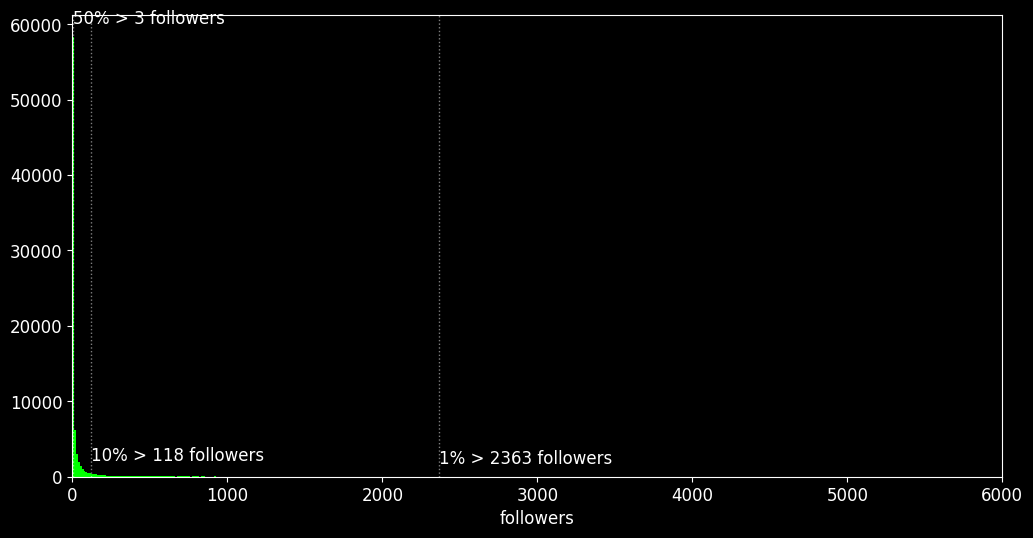

In [19]:
plot_hist(df, "followers", bins=500, xlim=(0, 6000), color='lime')

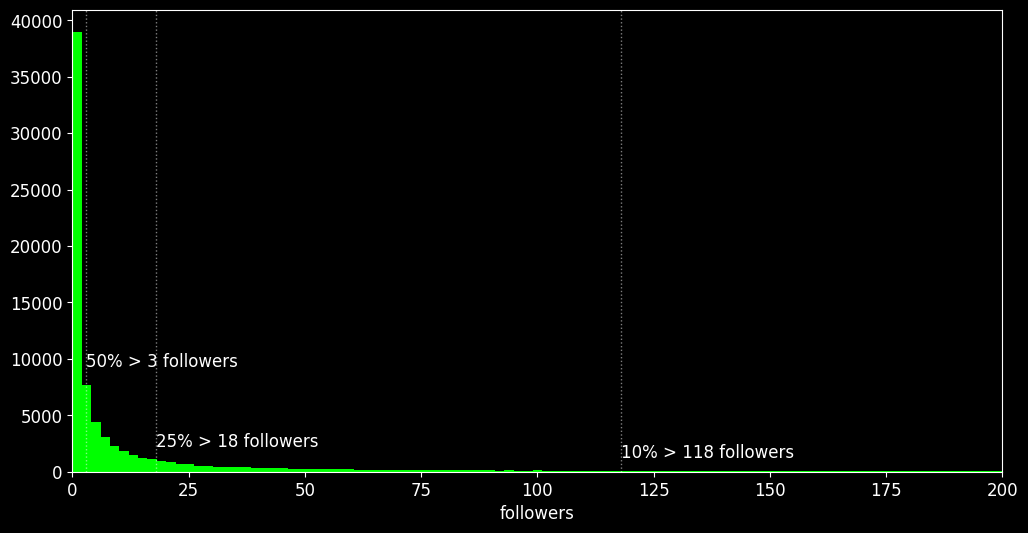

In [20]:
plot_hist(df, "followers", bins=100, quantiles=[0.5, 0.75, 0.9], xlim=(0, 200), color='lime')

Heavily left skewed data. Most stories do not get many followers at all. 
- Anything greater than 118 followers would put you in the top 10 percent of authors
- Anything greater than 2363 followers would put you in the top 1%. 
- Median amount of followers is 3 followers. 

Now we will only consider 'established' stories, with greater than 100 followers. This should put us roughly in the top 10% of fiction on RoyalRoad. This data is more reliable, because the way I gathered this data is by considering ALL fictions on RoyalRoad. Sam Hinton's analysis was on 'latest updates'. 

In [21]:
# Credits to Sam Hinton the author of this function
def get_established(df: pd.DataFrame, threshold=100) -> pd.DataFrame:
    df = df[df["followers"] > threshold].copy()

    # Convert decimal.Decimal to float for arithmetic operations
    df["monthly_earnings"] = df["monthly_earnings"].apply(lambda x: float(x) if x is not None else np.nan)
    df["patron_count"] = df["patron_count"].apply(lambda x: float(x) if x is not None else np.nan)

    # Handle NaNs in patron_count before division
    df["patron_value"] = np.where(
        df["patron_count"].notna(),
        df["monthly_earnings"] / df["patron_count"],
        np.nan
    )

    # Prevent division by 0 by replacing 0 with NaN
    # How many followers become patrons
    df["patron_rate"] = np.where(df["followers"] != 0, df["patron_count"] / df["followers"], np.nan)
    # Favorite to follower ratio
    df["favorite_rate"] = np.where(df["followers"] != 0, df["favorites"] / df["followers"], np.nan)
    # How many views turned into followers
    df["follow_rate_total"] = np.where(df["total_views"] != 0, df["followers"] / df["total_views"], np.nan)
    # Average views and follower ratios
    df["follow_rate_average"] = np.where(df["average_views"] != 0, df["followers"] / df["average_views"], np.nan)
    # Ratings to followers ratio
    df["rating_rate"] = np.where(df["followers"] != 0, df["ratings"] / df["followers"], np.nan)

    return df

df_established = get_established(df)


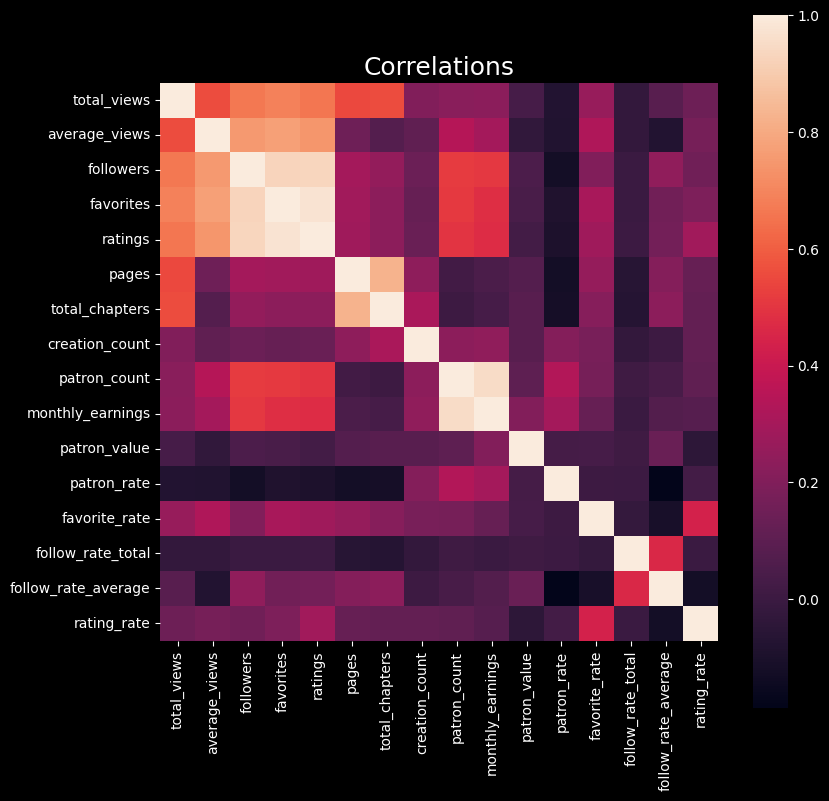

In [22]:
def plot_cor(df):    
    plt.figure(figsize=(9, 9))

    cor = df.corr(numeric_only=True)

    ax = sb.heatmap(cor, square=True)
    ax.set_title("Correlations", color="white", fontsize=18)
    plt.show()

df_established = df_established.drop(['fiction_id', 'patreon_id', 'member_count', 'paid_member_count'], axis=1)
plot_cor(df_established)

This pearson correlation grid indicates the linear correlation between two variables. If it is positive, it means as one increases, the other will likely increase in the same manner. If it's zero, there is zero correlation/relationship between them. If it is negative, it means as one increases, the other decreases and vice versa. 

- There is strong positive correlation most fiction stats. Which is to be expected because the more well received a story is, the better its stats will be across the board. However pages and total_chapters have low to moderate correlation average_views, followers, favorites and ratings. This suggests that the amount written for each fiction only slightly affects stats. Although readers do enjoy a large amount to read, it seems quality is quite important as well. 
- pages and total_chapters had low/zero correlation to patreon related statistics. 
- creation_count has low correlation to most fiction stats.  
- patron_count and monthly_earnings are moderately positively correlated to followers, favorites and ratings. Among the fiction stats, these seem to be the greatest indication that the author has a good community, and dedicated followers, leading to a higher patron count. 
- The member_count and paid_member_count related rows/columns should not be paid much attention to, because there is an extremly low amount of data related to them. 

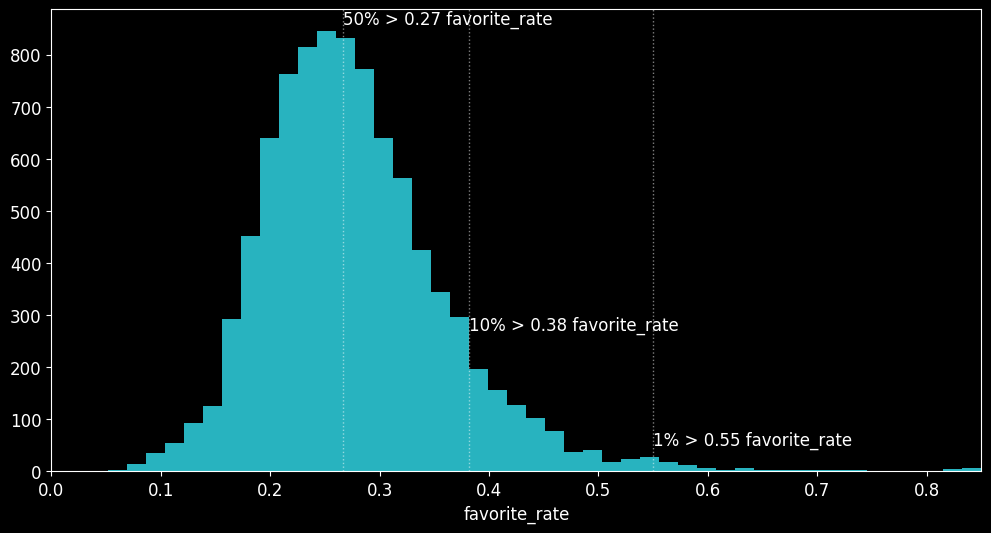

In [23]:
plot_hist(df_established, "favorite_rate", qfmt="%0.2f", color='#28B3BF', xlim=(0, 0.85))

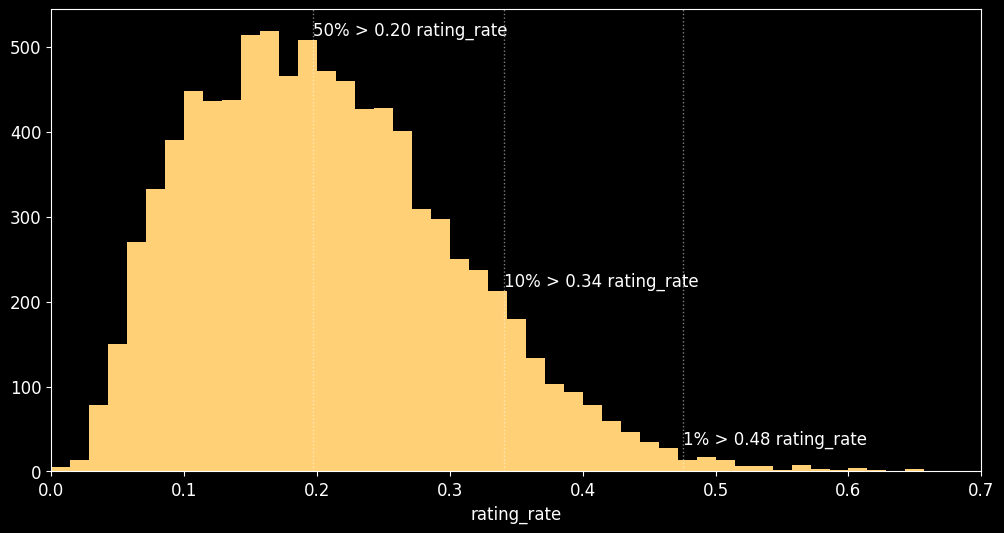

In [24]:
plot_hist(df_established, "rating_rate", qfmt="%0.2f", color='#FFD075', xlim=(0, 0.7))

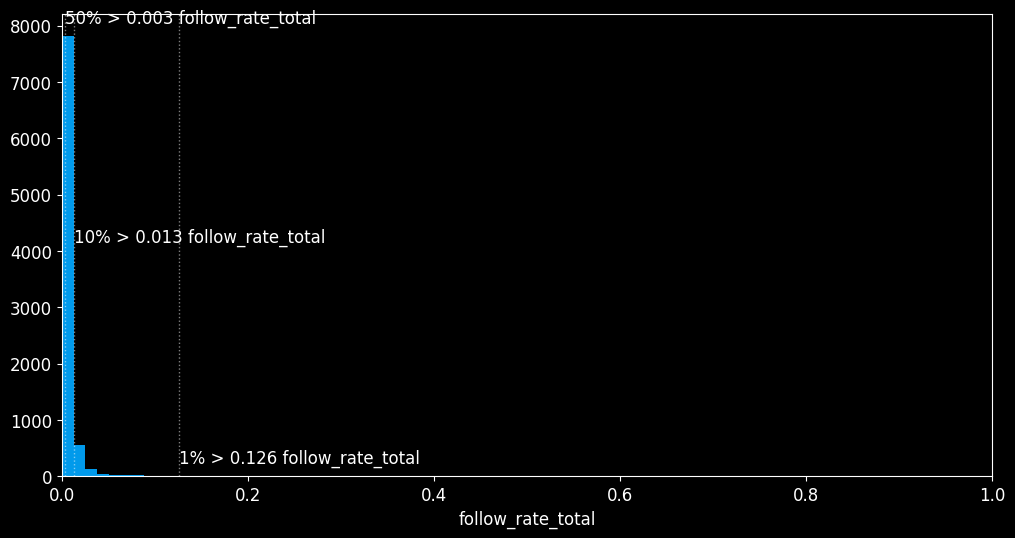

In [25]:
plot_hist(df_established, "follow_rate_total", qfmt="%0.3f", bins=80, xlim=(0, 1), color='#019AEB')

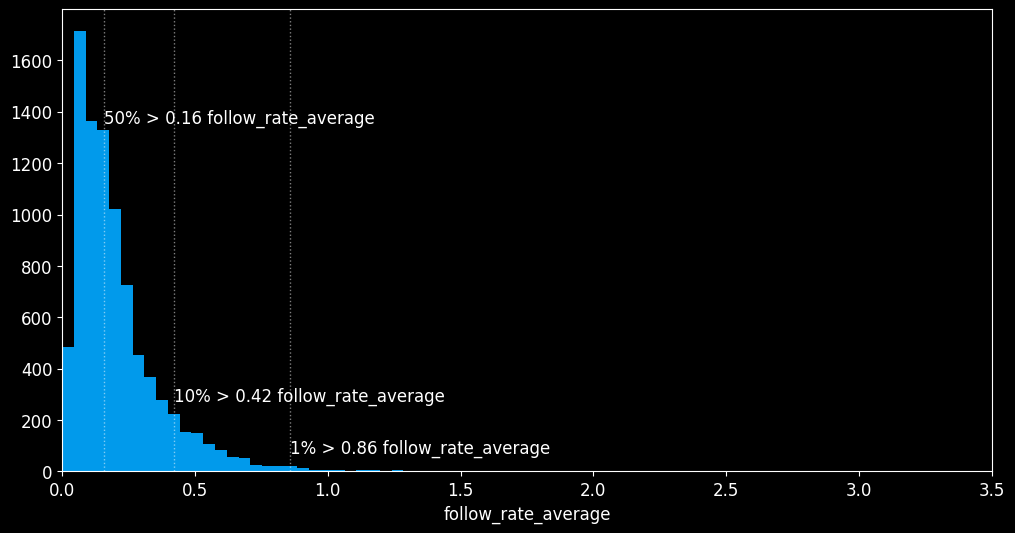

In [26]:
plot_hist(df_established, "follow_rate_average", qfmt="%0.2f", bins=80, xlim=(0, 3.5), color='#019AEB')

In [27]:
patreon_stats = query_to_df("""
SELECT 
    SUM(followers) as followers, 
    patreon_link, 
    monthly_earnings, 
    patron_count, 
    (patron_count / CAST(SUM(followers) AS NUMERIC)) as patron_rate,
    (monthly_earnings / patron_count) as patron_value
FROM 
    fictions f LEFT JOIN patreons p ON f.patreon_id = p.patreon_id
WHERE 
    patron_count IS NOT NULL AND monthly_earnings IS NOT NULL AND followers > 100
GROUP BY p.patreon_id
ORDER BY monthly_earnings DESC;
""")

decimal_cols = ['monthly_earnings', 'patron_rate', 'patron_value']
patreon_stats[decimal_cols] = patreon_stats[decimal_cols].astype(float)

In [28]:
patreon_fig_size = (10, 4)

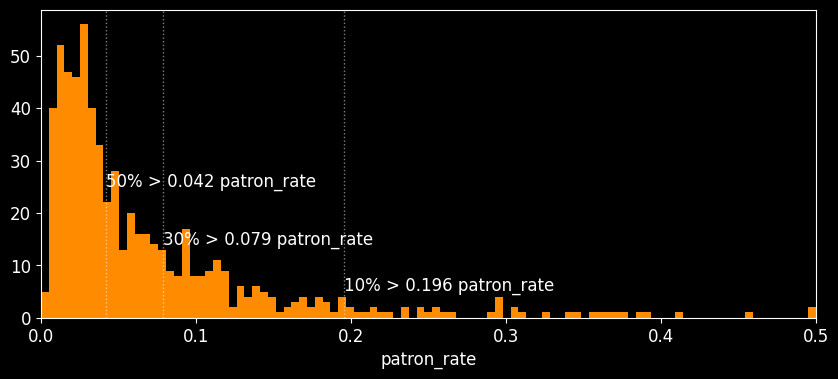

In [29]:
plot_hist(patreon_stats, "patron_rate", qfmt="%0.3f", bins=100, xlim=(0, 0.5), quantiles=[0.5, 0.7, 0.9], fig_size=patreon_fig_size, color='darkorange')

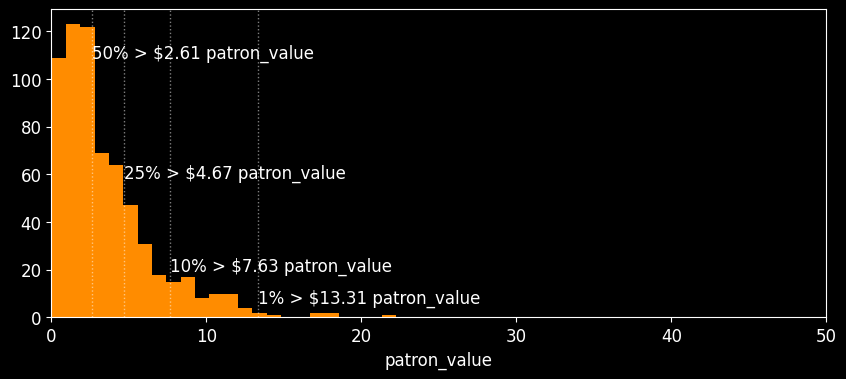

In [30]:
plot_hist(patreon_stats, "patron_value", qfmt="$%0.2f", bins=55, quantiles=[0.5, 0.75, 0.9, 0.99], fig_size=patreon_fig_size, color='darkorange', xlim=(0, 50))

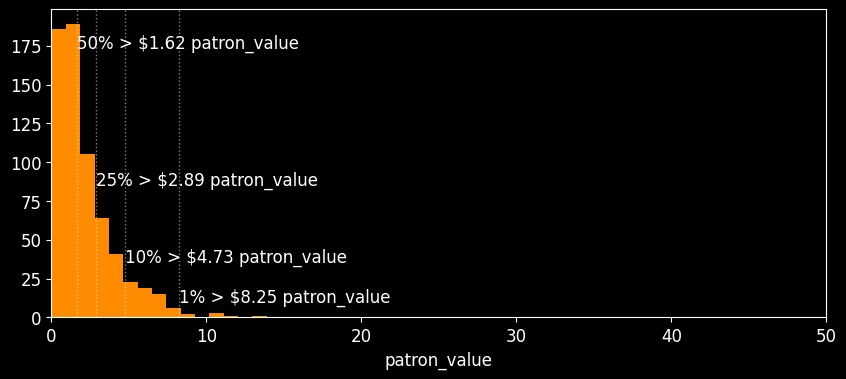

In [31]:
# USD alternative
patreon_stats['patron_value'] = patreon_stats['patron_value'] * 0.62
plot_hist(patreon_stats, "patron_value", qfmt="$%0.2f", bins=55, quantiles=[0.5, 0.75, 0.9, 0.99], fig_size=patreon_fig_size, color='darkorange', xlim=(0, 50))

I'm also curious about just the monthly earnings and patron counts. 

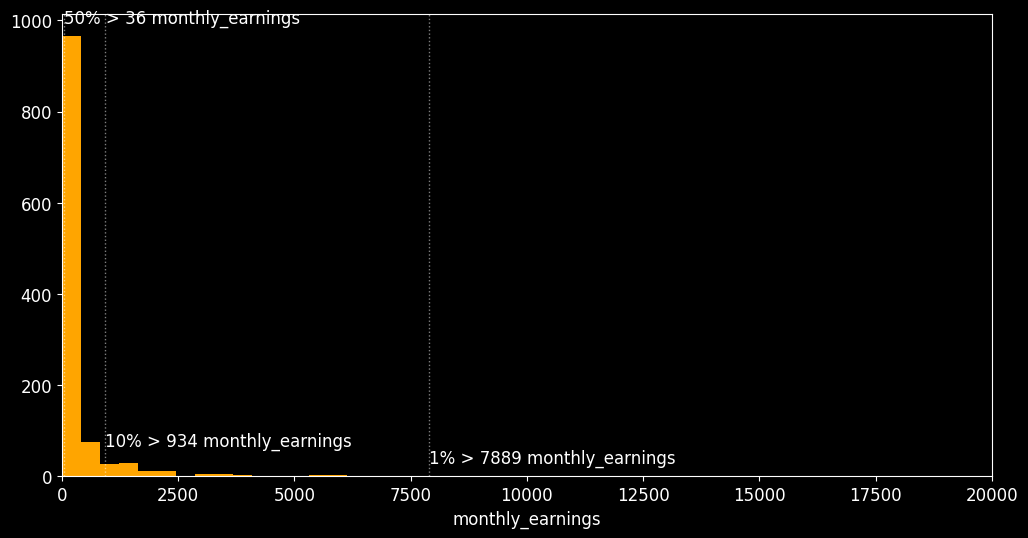

In [111]:
monthly_earnings = query_to_df("SELECT monthly_earnings FROM patreons WHERE monthly_earnings IS NOT NULL")
monthly_earnings['monthly_earnings'] = monthly_earnings['monthly_earnings'].astype(float)
# Convert to USD
monthly_earnings['monthly_earnings'] = monthly_earnings['monthly_earnings'] * 0.62
plot_hist(monthly_earnings, 'monthly_earnings', xlim=(0, 20000), color="orange")

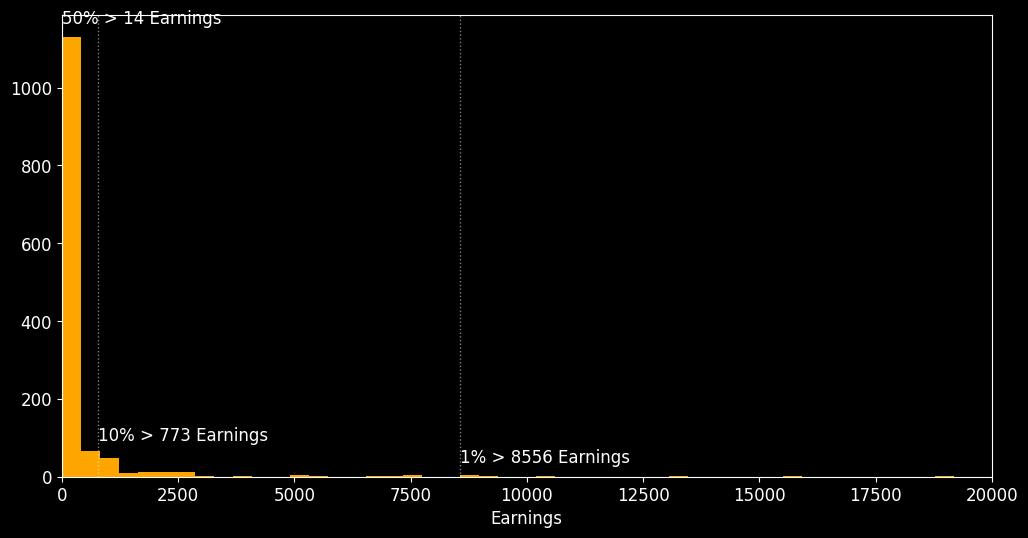

In [101]:
plot_hist(sh, 'Earnings', xlim=(0, 20000), color='orange')

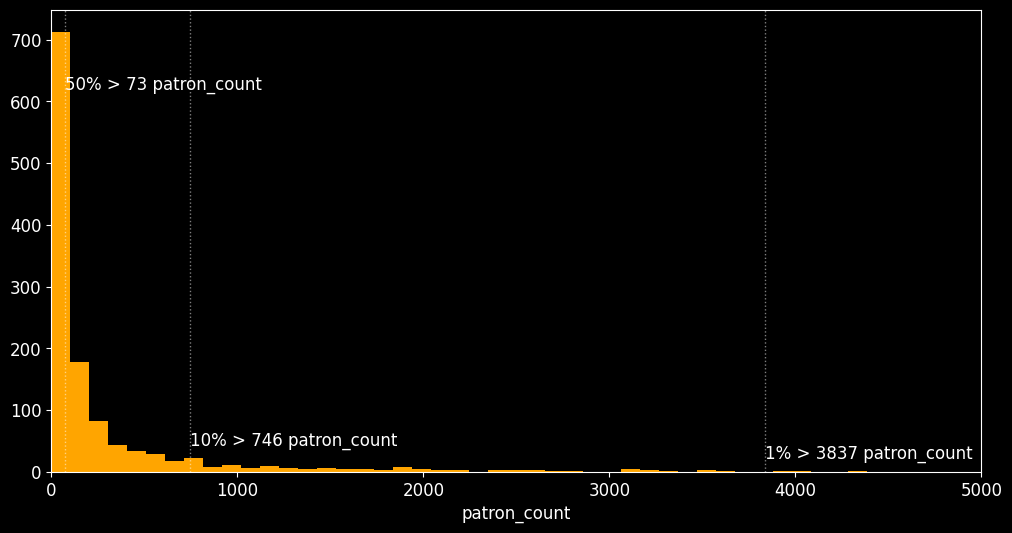

In [33]:
patron_count = query_to_df("SELECT patron_count FROM patreons WHERE patron_count IS NOT NULL")
patron_count['patron_count'] = patron_count['patron_count'].astype(float)
plot_hist(patron_count, 'patron_count', xlim=(0, 5000), color="orange")

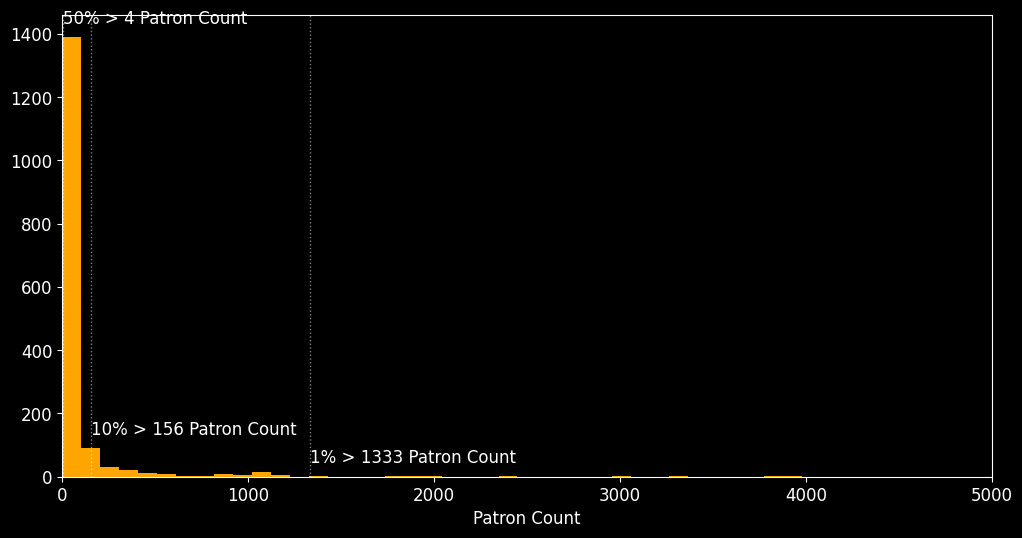

In [100]:
plot_hist(sh, 'Patron Count', xlim=(0, 5000), color='orange')

Summary (All Stories):
- Of all stories on the site, the top 10% have above 118 followers, while the top 1% have above 2363 followers.

Summary (Established Stories):
- patron_rate, i.e. 'What percentage of followers become patrons?', has a median of 0.042. This means the typical fiction can expect to have 4% of their followers become patrons. The top 10% of authors achieve a patron_rate of roughly 20%. Meaning a fifth of their followers become patrons.
- The median patron value is $1.62 USD. Only the top 1% of authors convert each patron into $8.25 USD or more. Conversions are as of February 2025. 
- Followers, Favorites and Ratings are the story stats that are most correlated to Patreon success.
- pages and total_chapters have low correlation to story stat success (followers favorites and ratings), and almost NO correlation to Patreon success. This has not changed from 2022. 
- Given a stories total views, the median follow rate is 0.3%. The top 10% achieve 1.3%, while the top 1% achieve 12.6%. Smaller stories (less total views), likely have larger follow rates because their friends will follow the story, boosting that follow rate.

From what I see, the metrics point towards RoyalRoad having fairly good user interaction. Although the total users have increased by a large amount since 2022, the culture appears to remain the same. Most metrics haven't changed that much, and the ones that did (patreon related) likely changed due to successful authors moving off RoyalRoad. Since patron rate seems to have increased, but patron value decreased, we can conclude that people are not willing to spend as much as they used to. Even if we account for inflation ($1 USD in 2022 is $1.09 USD in 2025), thats only a 9% increase. 

I would say that RoyalRoad is top heavy, however not overwhelmingly so. Getting over 100 followers would put you in the top 10%, however to get in the top 1% you would need over 2000 followers. It becomes exponentially more difficult to be one of the top fictions. Depending on the amount of people you reach and the quality of your story, getting 2000 followers does not seem impossible, especially on a site with millions of monthly users. 

In terms of making a living from writing on Patreon, the top 1% earn over $12,724 monthly. This may not be exactly accurate, as out of the 5147 patreons, only some disclose their earnings. So in reality, the top 1% may be earning less or more than this figure. However this gives a rough idea of how it is certainly possibly to make a living, and an idea of what the average writer may earn. The average writer unfortunately will likely not make a lot of money from RoyalRoad, however I would say if you want to become a writer, the odds that you make a living certainly aren't impossible. 

# My Analysis

Aim: To analyse trends amongst popular novels on RoyalRoad.
<br>
We will now analyse Genre, Labels and some other things, hoping to get a better understanding of the RoyalRoad ecosystem. We might be able to answer some questions such as:
- How do certain genres perform compared to others on RoyalRoad?
- What is the current state of RoyalRoad?

## Genre

Note that each fiction contributes to many genres. The earnings and total views from one fiction, contribute to all of that fictions genres for example. 

In [34]:
df = query_to_df(
    """
    SELECT 
        tag AS genre,
        SUM(total_views) AS total_views,
        COUNT(*) AS fiction_count,
        SUM(pages) AS total_pages,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY monthly_earnings) AS median_monthly_earnings,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY total_views) AS median_total_views,
        SUM(monthly_earnings) AS total_monthly_earnings,
        AVG(monthly_earnings) AS avg_monthly_earnings,
        SUM(patron_count) AS patron_count,
        SUM(followers) AS followers,
        SUM(favorites) AS favorites,
        AVG(ratings) AS ratings
    FROM fictions f 
    LEFT JOIN patreons p ON f.patreon_id = p.patreon_id
    CROSS JOIN LATERAL UNNEST(fiction_tags) AS tag
    WHERE followers > 100
    GROUP BY tag
    ORDER BY total_views DESC;
    """
)

df['follow_rate'] = df['total_views'] / df['followers']
df['favorite_rate'] = df['followers'] / df['favorites']
# df['patron_rate'] = df['total_views'] / df['patron_count']
df['patron_rate'] = df['patron_count'] / df['followers']
df['average_total_views_per_fiction'] = df['total_views'] / df['fiction_count']

print(len(df))
df.head()

64


,genre,total_views,fiction_count,total_pages,median_monthly_earnings,median_total_views,total_monthly_earnings,avg_monthly_earnings,patron_count,followers,favorites,ratings,follow_rate,favorite_rate,patron_rate,average_total_views_per_fiction
0,Fantasy,3427991757,7517,4978905,154.50,106320.0,1899734.08,1393.7887600880410858,846109,7292343,2261446,229.0164959425302647,470.080982,3.224637,0.116027,456031.895304
1,Adventure,3182170810,6938,4622002,166.35,105421.0,1820422.50,1482.4287459283387622,825785,6800702,2123280,231.4680023061400980,467.917990,3.202923,0.121426,458658.231479
2,Action,2772581637,6506,4246424,158.20,105004.5,1669425.64,1478.6763861824623561,782832,6166581,1882526,216.5133722717491546,449.614079,3.275695,0.126947,426157.644789
3,Magic,2543847682,5229,3742067,155.90,111103.0,1640969.34,1493.1477161055505005,705962,5496241,1708217,259.0812774909160451,462.834086,3.217531,0.128445,486488.369095
4,Male Lead,1967000768,4610,3158742,142.40,109693.5,1226464.87,1408.1112169919632606,580313,4565316,1375702,238.1806941431670282,430.857528,3.318536,0.127113,426681.294577


In [35]:
df.to_csv("output/genre_established.csv")

In [36]:
bar_fig_size = (18, 6)

<Axes: xlabel='genre'>

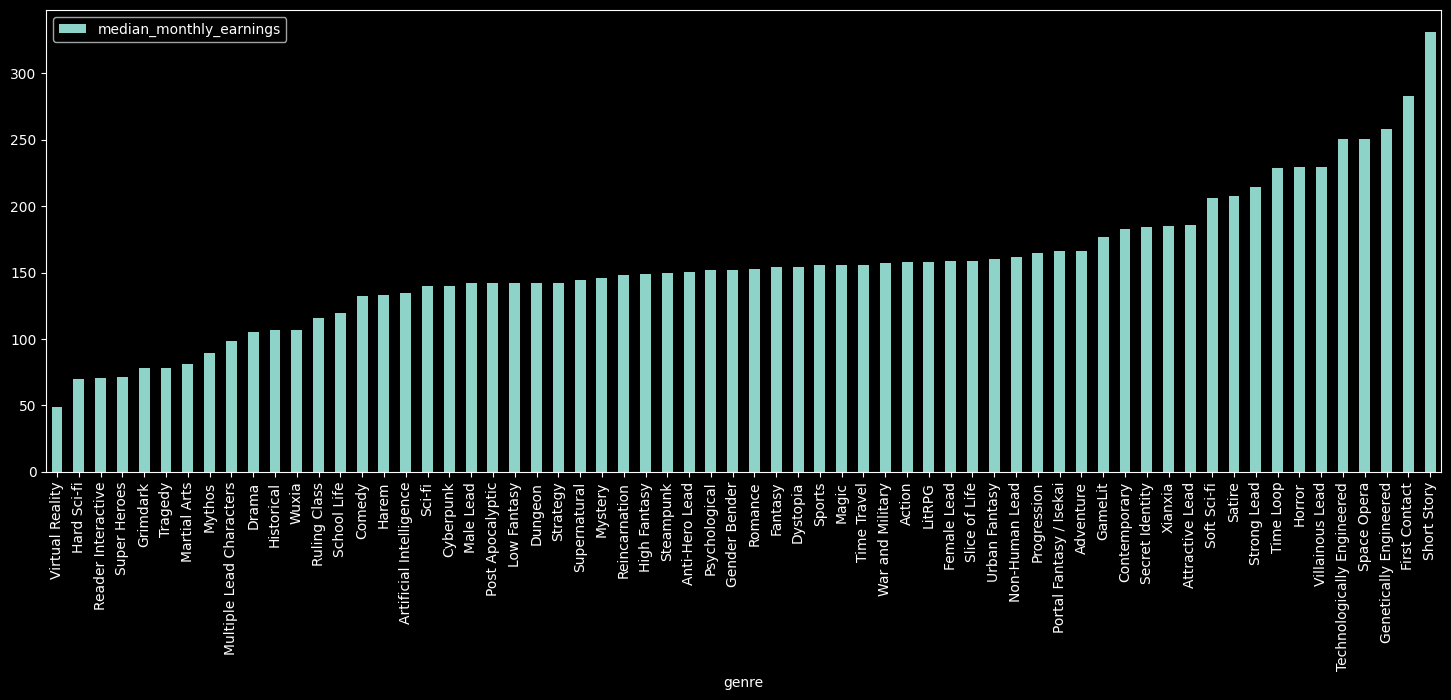

In [37]:
df.sort_values('median_monthly_earnings', inplace=True)
df.plot(kind='bar', x='genre', y='median_monthly_earnings', figsize=bar_fig_size)

<Axes: xlabel='genre'>

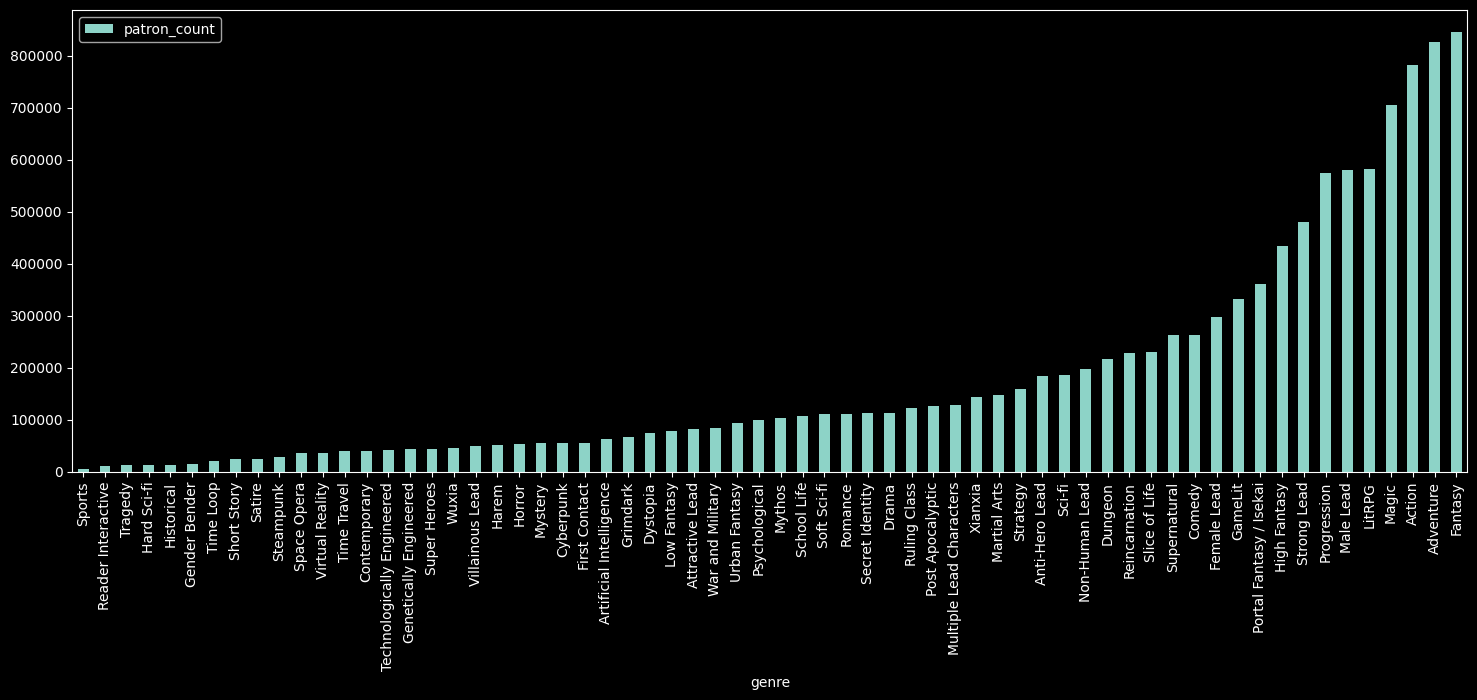

In [38]:
df.sort_values('patron_count', inplace=True)
df.plot(x='genre', y='patron_count', kind="bar", figsize=bar_fig_size)

<Axes: xlabel='genre'>

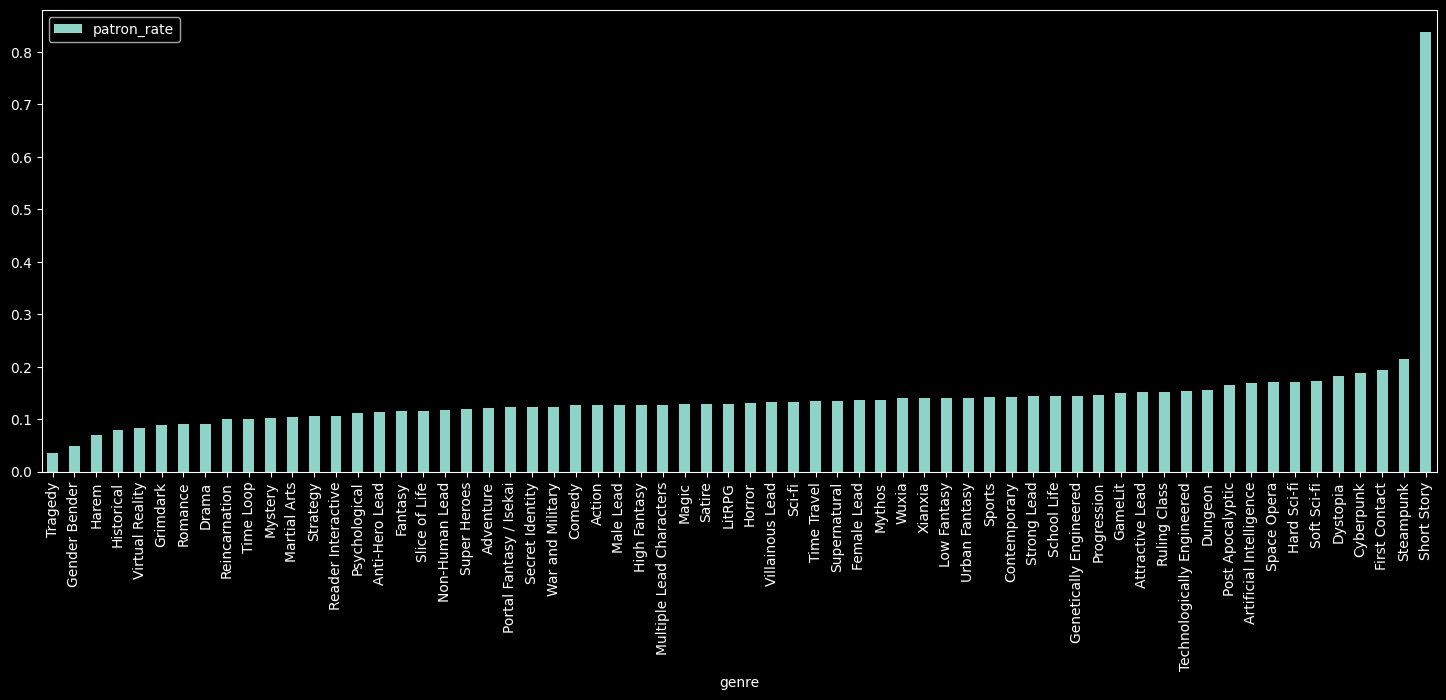

In [39]:
df.sort_values('patron_rate', inplace=True)
df.plot(x='genre', y='patron_rate', kind="bar", figsize=bar_fig_size)

<Axes: xlabel='genre'>

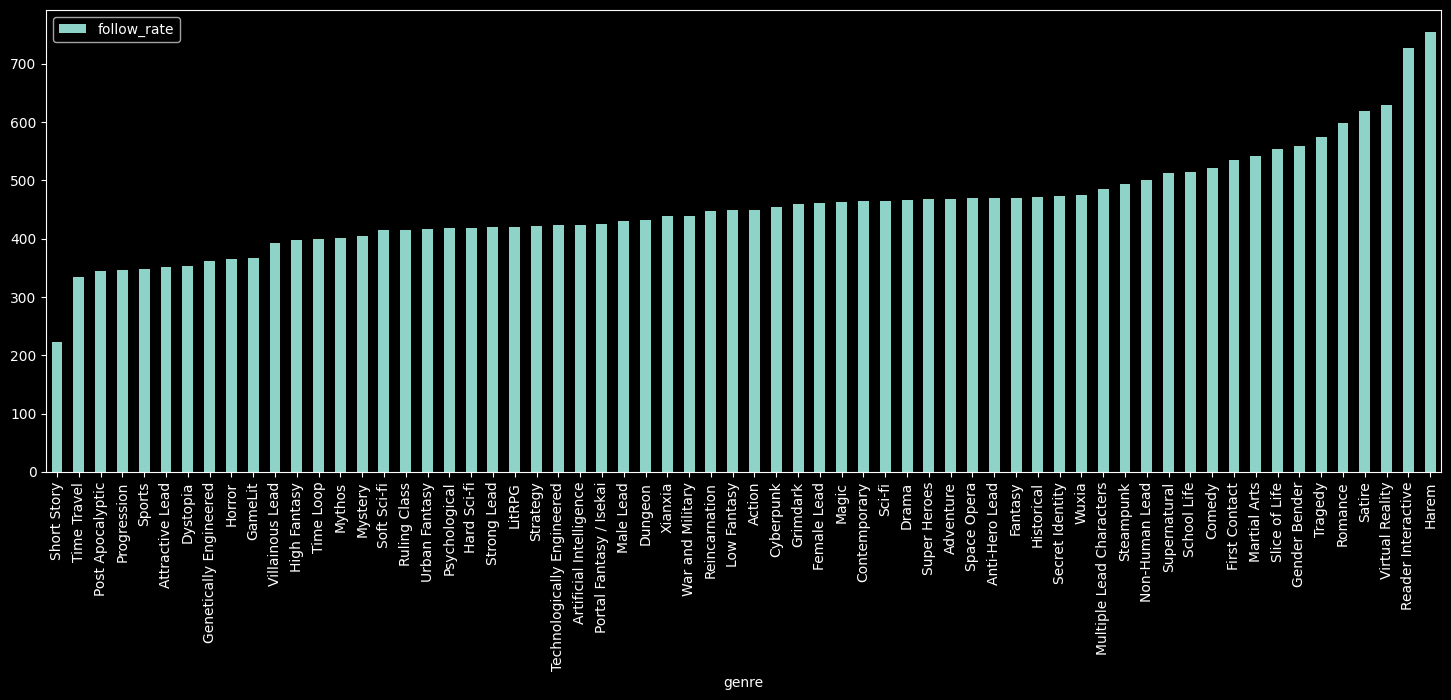

In [40]:
df.sort_values('follow_rate', inplace=True)
df.plot(x='genre', y='follow_rate', kind="bar", figsize=bar_fig_size)

<Axes: xlabel='genre'>

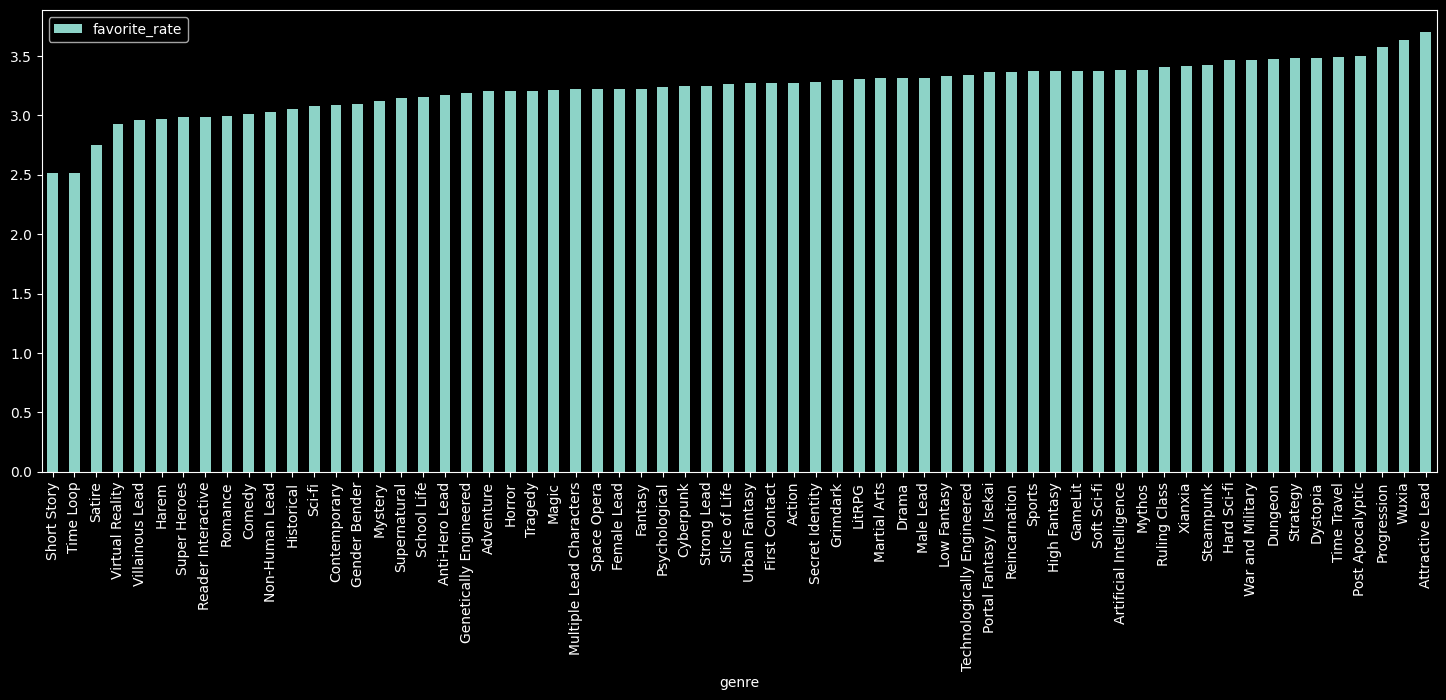

In [41]:
df.sort_values('favorite_rate', inplace=True)
df.plot(x='genre', y='favorite_rate', kind="bar", figsize=bar_fig_size)

## Labels

- All uppercase labels represent the STATE of the story, whether it is ONGOING, COMPLETED, HIATUS, etc.
- Original and Fan Fiction are the two TYPES of stories.
- STUB means that parts of the story were taken down. This is often because the author moved from publishing on RoyalRoad to other places like Kindle. 

In [42]:
labels = query_to_df("""
WITH unique_fictions AS (
    SELECT DISTINCT ON (title, author) *
    FROM fictions
    ORDER BY title, author, fiction_id
)
SELECT
    label AS label,
    COUNT(*) AS fiction_count
FROM
    unique_fictions f
CROSS JOIN LATERAL
    UNNEST(f.labels) AS label
GROUP BY
    label
ORDER BY
    fiction_count DESC;
""")

labels
# labels.to_csv('output/labels.csv')

,label,fiction_count
0,Original,75494
1,HIATUS,68953
2,ONGOING,6968
3,Fan Fiction,6880
4,COMPLETED,4856
5,STUB,878
6,DROPPED,719


In [43]:
types = ["Original", "Fan Fiction"]
labels_type = labels[labels['label'].isin(types)]
labels_state = labels[~labels['label'].isin(types)]

Just verify that they are both the same length. They should be, as each fiction can only be one of a STATE and TYPE. 

In [44]:
print(labels_type.fiction_count.sum())
print(labels_state.fiction_count.sum())

82374
82374


In [45]:
labels_type.reset_index(inplace=True, drop=True)
labels_type.loc[:, 'percentages'] = labels_type['fiction_count'] / labels_type['fiction_count'].sum()
labels_type

C:\Users\haru\AppData\Local\Temp\ipykernel_27100\1673958379.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels_type.loc[:, 'percentages'] = labels_type['fiction_count'] / labels_type['fiction_count'].sum()


,label,fiction_count,percentages
0,Original,75494,0.916479
1,Fan Fiction,6880,0.083521


In [46]:
labels_state.reset_index(inplace=True, drop=True)
labels_state.loc[:, 'percentages'] = labels_state['fiction_count'] / labels_state['fiction_count'].sum()
labels_state

C:\Users\haru\AppData\Local\Temp\ipykernel_27100\583227957.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels_state.loc[:, 'percentages'] = labels_state['fiction_count'] / labels_state['fiction_count'].sum()


,label,fiction_count,percentages
0,HIATUS,68953,0.837072
1,ONGOING,6968,0.084590
2,COMPLETED,4856,0.058951
3,STUB,878,0.010659
4,DROPPED,719,0.008728


In [47]:
labels_type.to_csv('output/labels_type.csv')
labels_state.to_csv('output/labels_state.csv')

In [48]:
labels_established = query_to_df("""
WITH unique_fictions_established AS (
    SELECT DISTINCT ON (title, author) *
    FROM fictions
    WHERE followers > 100
    ORDER BY title, author, fiction_id
)
SELECT
    label AS label,
    COUNT(*) AS fiction_count
FROM
    unique_fictions_established f
CROSS JOIN LATERAL
    UNNEST(f.labels) AS label
GROUP BY
    label
ORDER BY
    fiction_count DESC;
""")

labels_established

,label,fiction_count
0,Original,8118
1,HIATUS,5760
2,ONGOING,1556
3,Fan Fiction,788
4,COMPLETED,701
5,STUB,698
6,DROPPED,191


In [49]:
labels_established_type = labels_established[labels_established['label'].isin(types)]
labels_established_state = labels_established[~labels_established['label'].isin(types)]

In [50]:
print(labels_established_state.fiction_count.sum())
print(labels_established_type.fiction_count.sum())

8906
8906


In [51]:
labels_established_type.reset_index(inplace=True, drop=True)
labels_established_type.loc[:, 'percentages'] = labels_established_type['fiction_count'] / labels_established_type['fiction_count'].sum()
labels_established_type

C:\Users\haru\AppData\Local\Temp\ipykernel_27100\559285070.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels_established_type.loc[:, 'percentages'] = labels_established_type['fiction_count'] / labels_established_type['fiction_count'].sum()


,label,fiction_count,percentages
0,Original,8118,0.91152
1,Fan Fiction,788,0.08848


In [52]:
labels_established_state.reset_index(inplace=True, drop=True)
labels_established_state.loc[:, 'percentages'] = labels_established_state['fiction_count'] / labels_established_state['fiction_count'].sum()
labels_established_state

C:\Users\haru\AppData\Local\Temp\ipykernel_27100\427281929.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels_established_state.loc[:, 'percentages'] = labels_established_state['fiction_count'] / labels_established_state['fiction_count'].sum()


,label,fiction_count,percentages
0,HIATUS,5760,0.646755
1,ONGOING,1556,0.174714
2,COMPLETED,701,0.078711
3,STUB,698,0.078374
4,DROPPED,191,0.021446


In [53]:
labels_established_type.to_csv('output/labels_established_type.csv')
labels_established_state.to_csv('output/labels_established_state.csv')

I don't think it would be very helpful to know the distributions of whether COMPLETED fictions are Original or Fan Fiction, or similar. So we will leave looking at the distribution of labels here, and move onto analysing the stats of COMPLETED fictions. 

In [54]:
completed = query_to_df("""
SELECT title, author, total_views, average_views, followers, favorites, ratings, pages, total_chapters, labels
FROM fictions f
LEFT JOIN patreons p ON f.patreon_id = p.patreon_id
WHERE followers > 100 AND 'COMPLETED' = ANY(f.labels);
""")
print(len(completed))

completed['average_pages_per_chapter'] = completed['pages'] / completed['total_chapters']
completed.head()

701


,title,author,total_views,average_views,followers,favorites,ratings,pages,total_chapters,labels,average_pages_per_chapter
0,A Journey of Black and Red,Mecanimus,11249165,47068,13036,6883,4641,4585,239,"[Original, COMPLETED]",19.184100
1,"Wander West, In Shadow [Slow Burn Dark Fantasy]",CloverCloverClover,120471,4462,1883,456,245,743,27,"[Original, COMPLETED]",27.518519
2,Downtown Druid,Seersucker,4537931,22690,10968,2725,1995,1274,201,"[Original, COMPLETED]",6.338308
3,"Rock falls, everyone dies",zechamp,1542224,73439,5779,4898,4180,128,21,"[Original, COMPLETED]",6.095238
4,Chasing Sunlight,InadvisablyCompelled,451822,15061,3859,1144,732,521,30,"[Original, COMPLETED]",17.366667


Analysing the patron_count and monthly_earnings is not very applicable for COMPLETED fictions, after all we do not know how long it has been since it has been completed, and whether the author is still writing/getting patrons another way. 
So lets stick to analysing the novel stats of COMPLETED fictions. 

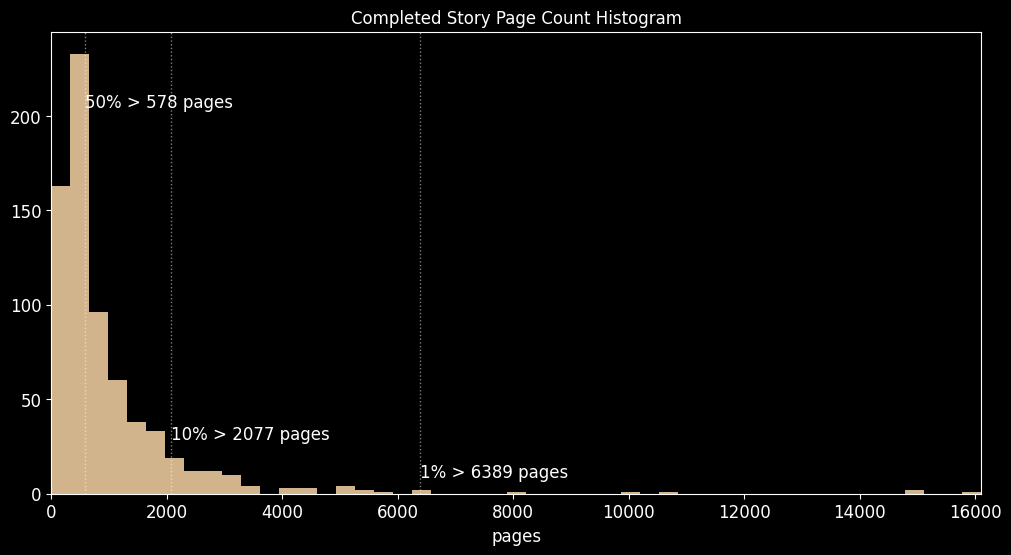

In [55]:
plot_hist(completed, 'pages', title='Completed Story Page Count Histogram', color='tan')

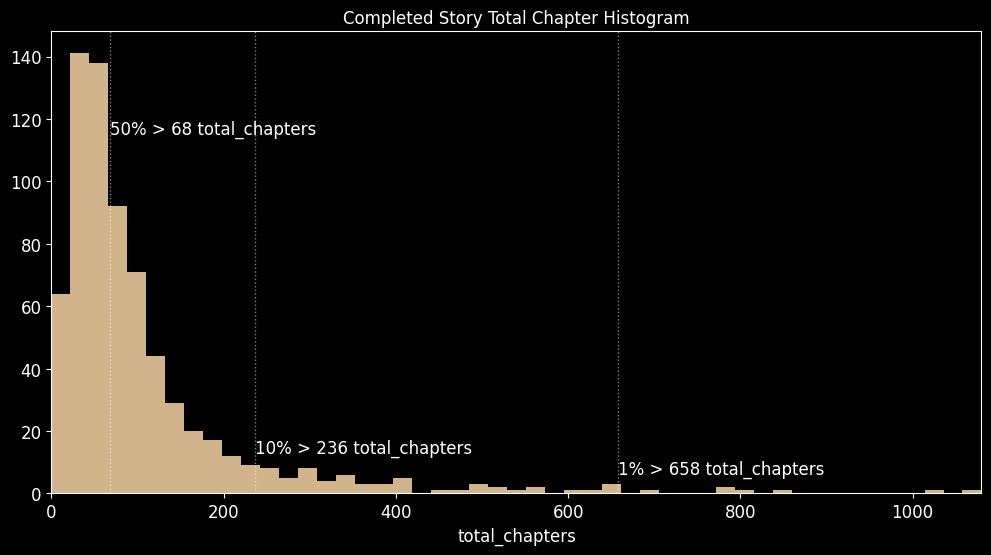

In [56]:
plot_hist(completed, 'total_chapters', title='Completed Story Total Chapter Histogram', color='tan')

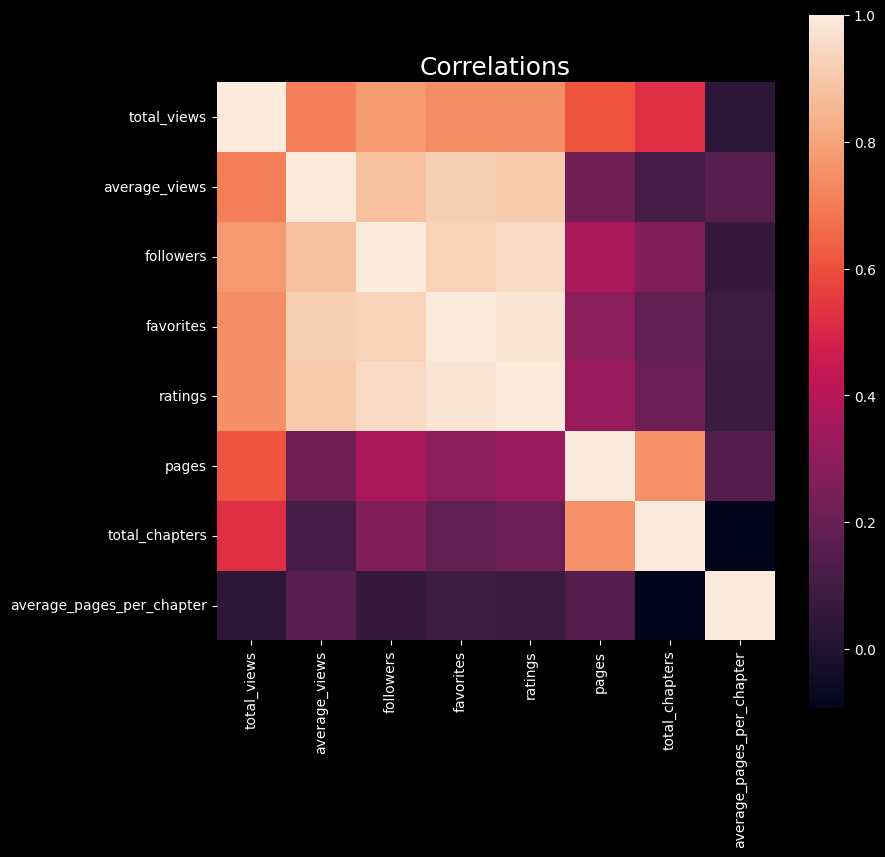

In [57]:
plot_cor(completed)

Now if we take a look at the average pages per chapter, we will realise there are some outliers. Maybe fictions that dumped all of their work into a few chapters.

<Axes: >

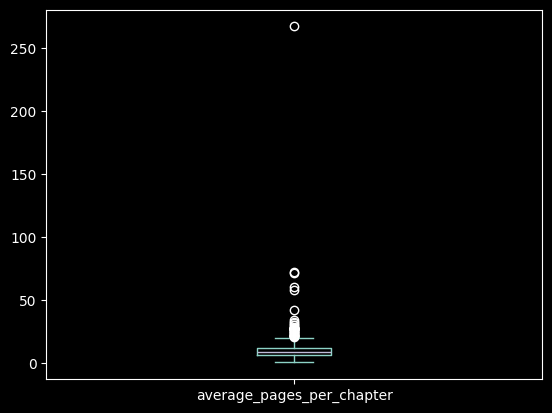

In [58]:
completed['average_pages_per_chapter'].plot(kind='box')

Lets remove outliers in terms of average pages per chapter. I assume its roughly normally distributed, so anything above 2std dev from the mean lets get rid of. 

In [59]:
std = completed['average_pages_per_chapter'].std()
mean = completed['average_pages_per_chapter'].mean()

In [60]:
completed = completed[completed['average_pages_per_chapter'] < (mean + 2* std)]

<Axes: >

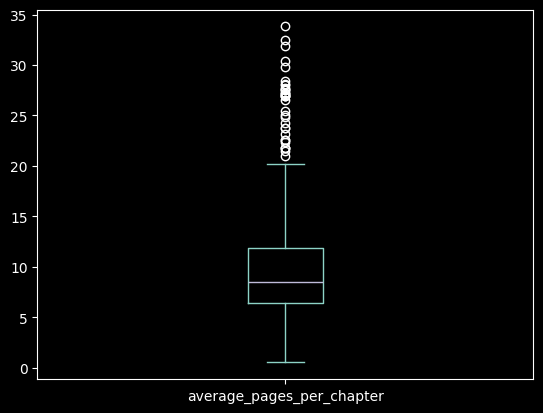

In [61]:
completed['average_pages_per_chapter'].plot(kind='box')

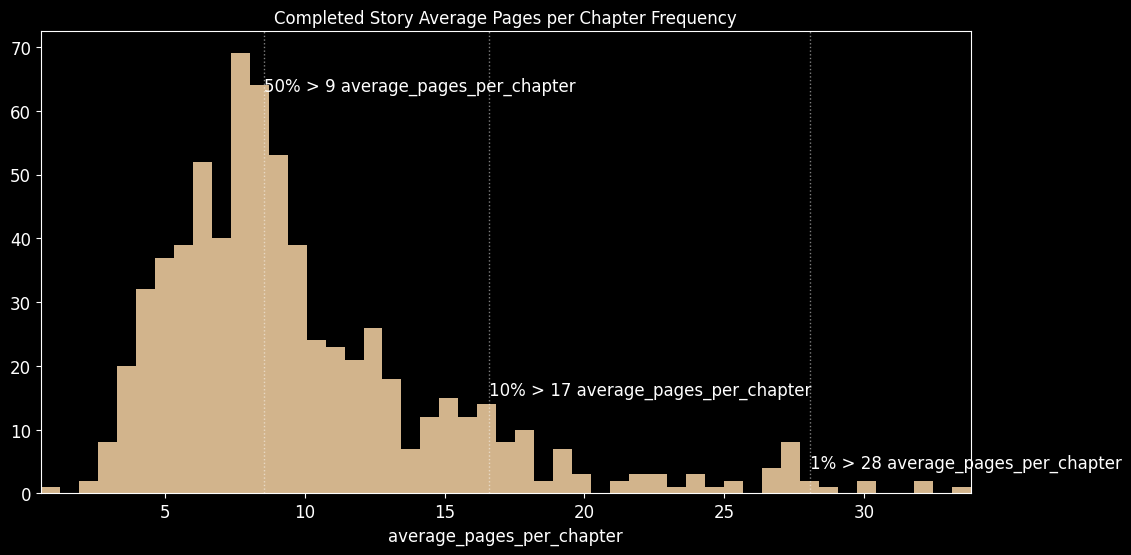

In [62]:
plot_hist(completed, 'average_pages_per_chapter', title='Completed Story Average Pages per Chapter Frequency', color='tan')

# Title Analysis

In [63]:
fictions = query_to_df("SELECT * FROM fictions;")

In [64]:
fictions.head()

,fiction_id,link,title,author,total_views,average_views,followers,favorites,ratings,pages,total_chapters,first_chapter_release_datetime,patreon_id,labels,fiction_tags
0,1,https://www.royalroad.com/fiction/62125/ghost-...,Ghost in the City: Cyberpunk Gamer SI,Seras,10002043,47629,15144,6914,4494,2732,211,2022-12-20 20:34:23,NaN,"[Fan Fiction, ONGOING]","[LitRPG, Reincarnation, Female Lead, Sci-fi, S..."
1,2,https://www.royalroad.com/fiction/26675/a-jour...,A Journey of Black and Red,Mecanimus,11249165,47068,13036,6883,4641,4585,239,2019-08-18 19:59:48,2750.0,"[Original, COMPLETED]","[Urban Fantasy, Villainous Lead, Female Lead, ..."
2,3,https://www.royalroad.com/fiction/39408/beware...,Beware Of Chicken,Casualfarmer,16230401,72135,33713,18837,13281,1987,225,2021-01-14 11:24:47,3859.0,"[Original, STUB]","[Portal Fantasy / Isekai, Xianxia, Comedy, Mal..."
3,4,https://www.royalroad.com/fiction/104561/for-t...,For the Glory of Rome: Chronicles of an Isekai...,zaifyr,147222,7749,3919,717,428,192,21,2025-01-30 03:08:20,4803.0,"[Original, ONGOING]","[LitRPG, Portal Fantasy / Isekai, Progression,..."
4,5,https://www.royalroad.com/fiction/73112/cultis...,Cultist of Cerebon - Litrpg/Isekai,Fizzicks,2123150,53079,14101,3579,2436,1024,40,2023-08-20 09:55:02,5146.0,"[Original, ONGOING]","[LitRPG, Portal Fantasy / Isekai, Ruling Class..."


Does title length impact any metrics?

In [65]:
fictions.drop(['fiction_id', 'link', 'author', 'labels', 'fiction_tags', 'first_chapter_release_datetime', 'patreon_id'], axis = 1, inplace=True)
fictions.reset_index(drop=True)
fictions.drop_duplicates('title', inplace=True)

In [66]:
len(fictions)

79931

In [67]:
fictions['title_char_length'] = fictions['title'].str.len()

In [68]:
fictions.head()

,title,total_views,average_views,followers,favorites,ratings,pages,total_chapters,title_char_length
0,Ghost in the City: Cyberpunk Gamer SI,10002043,47629,15144,6914,4494,2732,211,37
1,A Journey of Black and Red,11249165,47068,13036,6883,4641,4585,239,26
2,Beware Of Chicken,16230401,72135,33713,18837,13281,1987,225,17
3,For the Glory of Rome: Chronicles of an Isekai...,147222,7749,3919,717,428,192,21,55
4,Cultist of Cerebon - Litrpg/Isekai,2123150,53079,14101,3579,2436,1024,40,34


In [69]:
fictions['title_char_length'].describe()

count    79931.000000
mean        24.338242
std         14.658883
min          1.000000
25%         15.000000
50%         20.000000
75%         31.000000
max        120.000000
Name: title_char_length, dtype: float64

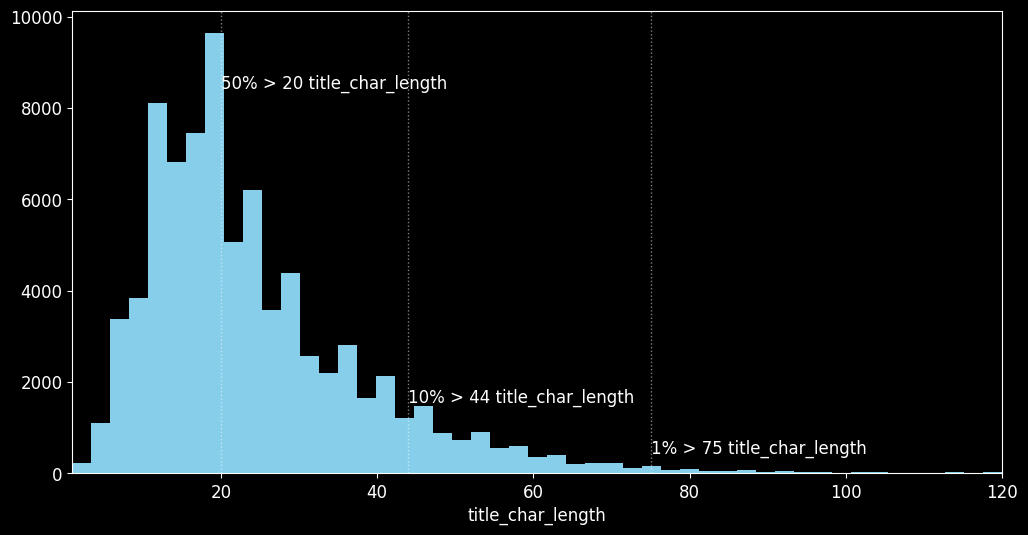

In [70]:
plot_hist(fictions, 'title_char_length')

The average character length of a title is 24, the median is 20. There exists a 1 char length title and a 120 character length title.

Lets plot a bar chart of different title character lengths, and their total_views, as this will give us an indication of whether titles of certain length might deter people from viewing. Although it could just be that there are very few titles of certain length.

There could be the fact that there are simply few very few fiction of a certain title length. So lets also plot one that is the average_total_views_per_fiction for each title char length

In [71]:
fictions_established = fictions[fictions['followers'] > 100]
fictions_established

,title,total_views,average_views,followers,favorites,ratings,pages,total_chapters,title_char_length
0,Ghost in the City: Cyberpunk Gamer SI,10002043,47629,15144,6914,4494,2732,211,37
1,A Journey of Black and Red,11249165,47068,13036,6883,4641,4585,239,26
2,Beware Of Chicken,16230401,72135,33713,18837,13281,1987,225,17
3,For the Glory of Rome: Chronicles of an Isekai...,147222,7749,3919,717,428,192,21,55
4,Cultist of Cerebon - Litrpg/Isekai,2123150,53079,14101,3579,2436,1024,40,34
...,...,...,...,...,...,...,...,...,...
35282,Battlefield Restart (Old Version),223008,3232,301,67,2,483,69,33
35704,Synapse of Ash: Cyber Hunter Origins 1,0,0,117,32,7,0,0,38
37667,Seikatsu ONLINE,94389,5552,167,49,2,115,17,15
50166,Racial Traits,5995,2998,126,28,1,6,2,13


In [72]:
title_lengths = fictions_established.groupby('title_char_length').agg(
    total_views=('total_views', 'sum'), 
    fiction_count=('title_char_length', 'count')  # Counting occurrences
)
title_lengths.reset_index(inplace=True)
title_lengths['average_total_views_per_fiction'] = title_lengths['total_views'] / title_lengths['fiction_count']

In [73]:
title_lengths.head()

,title_char_length,total_views,fiction_count,average_total_views_per_fiction
0,1,300888,3,100296.000000
1,2,198366,3,66122.000000
2,3,414511,8,51813.875000
3,4,15990566,34,470310.764706
4,5,42731566,61,700517.475410


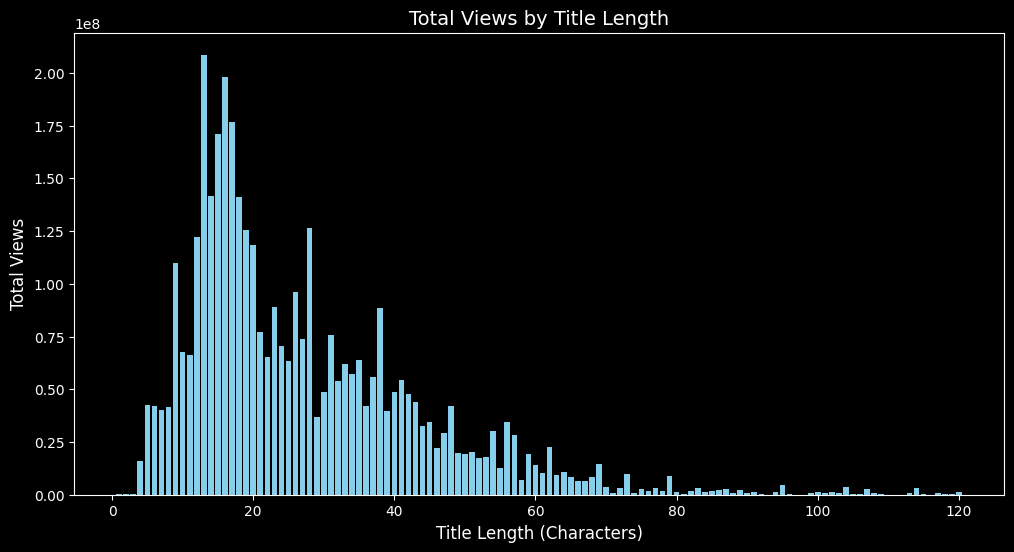

In [74]:
plt.figure(figsize=(12, 6))
plt.bar(title_lengths["title_char_length"], title_lengths["total_views"], color="skyblue")

plt.xlabel("Title Length (Characters)", fontsize=12)
plt.ylabel("Total Views", fontsize=12)
plt.title("Total Views by Title Length", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()


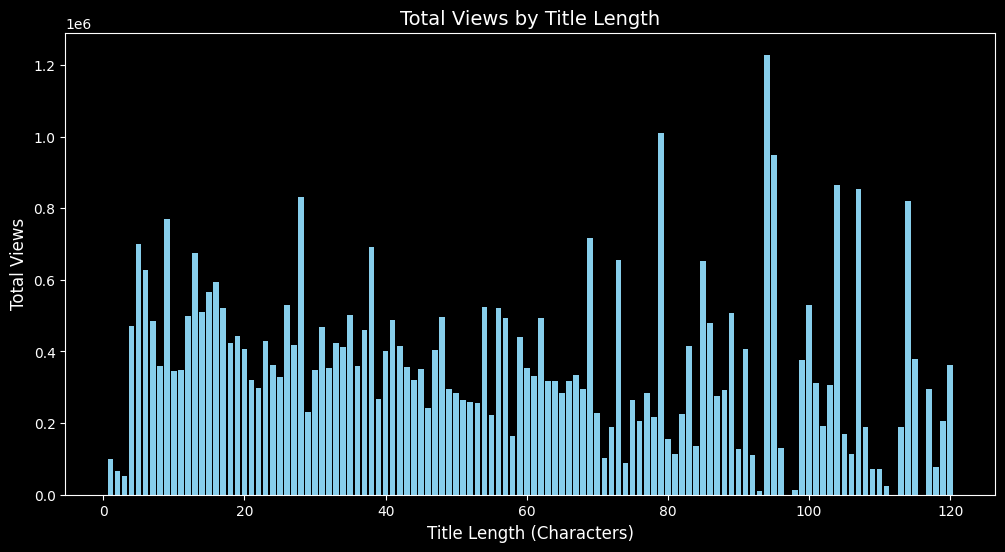

In [75]:
plt.figure(figsize=(12, 6))
plt.bar(title_lengths["title_char_length"], title_lengths["average_total_views_per_fiction"], color="skyblue")

plt.xlabel("Title Length (Characters)", fontsize=12)
plt.ylabel("Total Views", fontsize=12)
plt.title("Total Views by Title Length", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

Title Length doesn't impact anything.

Are there any popular 'buzz words' in titles that appear frequently?

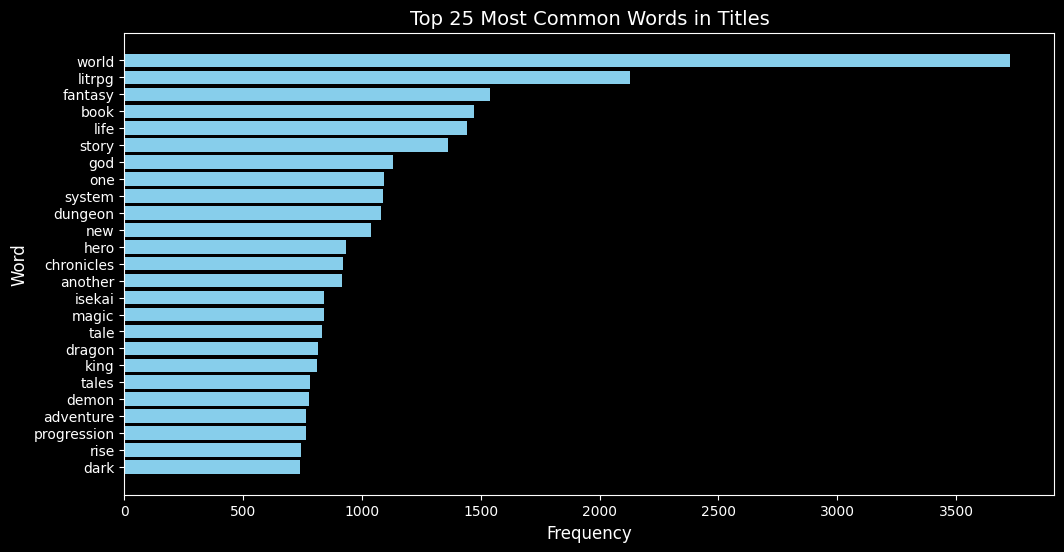

In [76]:
banned_words = {"the", "my", "of", "and", "in", "to", "a", "for", "on", "with", "is", "at", "i", "s", "an", "1", "as", "from"}

all_words = []
for title in fictions['title']:
    words = re.findall(r'\b\w+\b', title.lower())
    filtered_words = filter(lambda x: x not in banned_words, words)
    all_words.extend(filtered_words)

word_counts = Counter(all_words)

common_words = word_counts.most_common(25)

word_df = pd.DataFrame(common_words, columns=['word', 'count'])

plt.figure(figsize=(12, 6))
plt.barh(word_df['word'][::-1], word_df['count'][::-1], color='skyblue')
plt.xlabel("Frequency", fontsize=12)
plt.ylabel("Word", fontsize=12)
plt.title("Top 25 Most Common Words in Titles", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


# Timeline

In [102]:
time_df = query_to_df("""
SELECT DATE_TRUNC('month', first_chapter_release_datetime) AS month, COUNT(*) AS fiction_count
FROM fictions
WHERE first_chapter_release_datetime IS NOT NULL
GROUP BY month
ORDER BY month;
""")

In [105]:
time_df.to_csv("output/fc_timeline.csv")

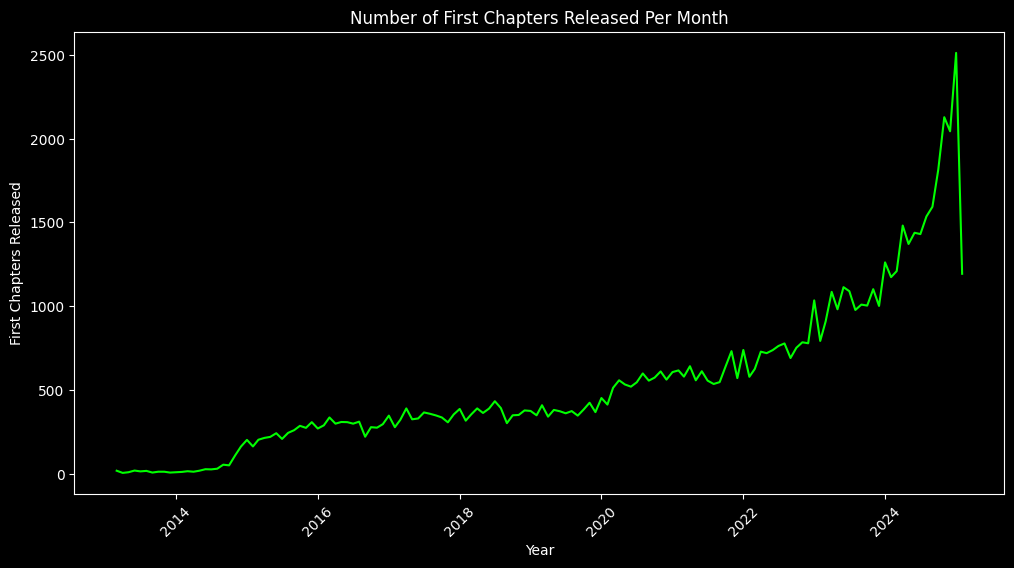

In [110]:
time_df["month"] = pd.to_datetime(time_df["month"])

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(time_df["month"], time_df["fiction_count"], linestyle="-", color="lime")

# Formatting
plt.title("Number of First Chapters Released Per Month")
plt.xlabel("Year")
plt.ylabel("First Chapters Released")
# plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.show()